In [1]:
import os
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.measure import label, regionprops

# add root mars project folder to path
import sys
sys.path.append("..")

import util.data as data_util
import util.api as api_util

## Download Data & YOLO Library

In [2]:
data_util.download_training_dataset()

In [3]:
api_util.download_yolo_library()

## Visualizing Images

In [6]:
SAMPLE_IMAGE_IDX = 98
IMAGE_PATH = str(data_util.IMAGES_DIR / data_util.train_image_files[SAMPLE_IMAGE_IDX])

### Basic Image

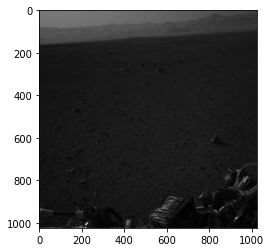

In [7]:
image = cv2.imread(str(IMAGE_PATH))

plt.imshow(np.flip(image, 2))
plt.show()

### Color Key

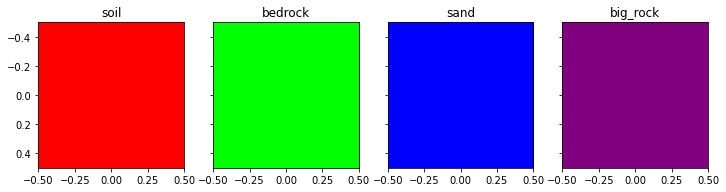

In [9]:
data_util.plot_color_key()

### With Mask and Segmentation

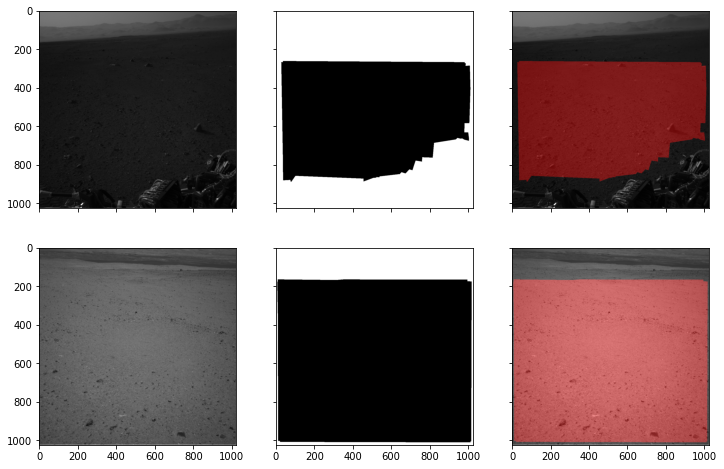

In [10]:
data_util.plot_images_with_mask_and_tint([SAMPLE_IMAGE_IDX, 100])

### With Mask, Segmentation, and Inferred Bounding Boxes

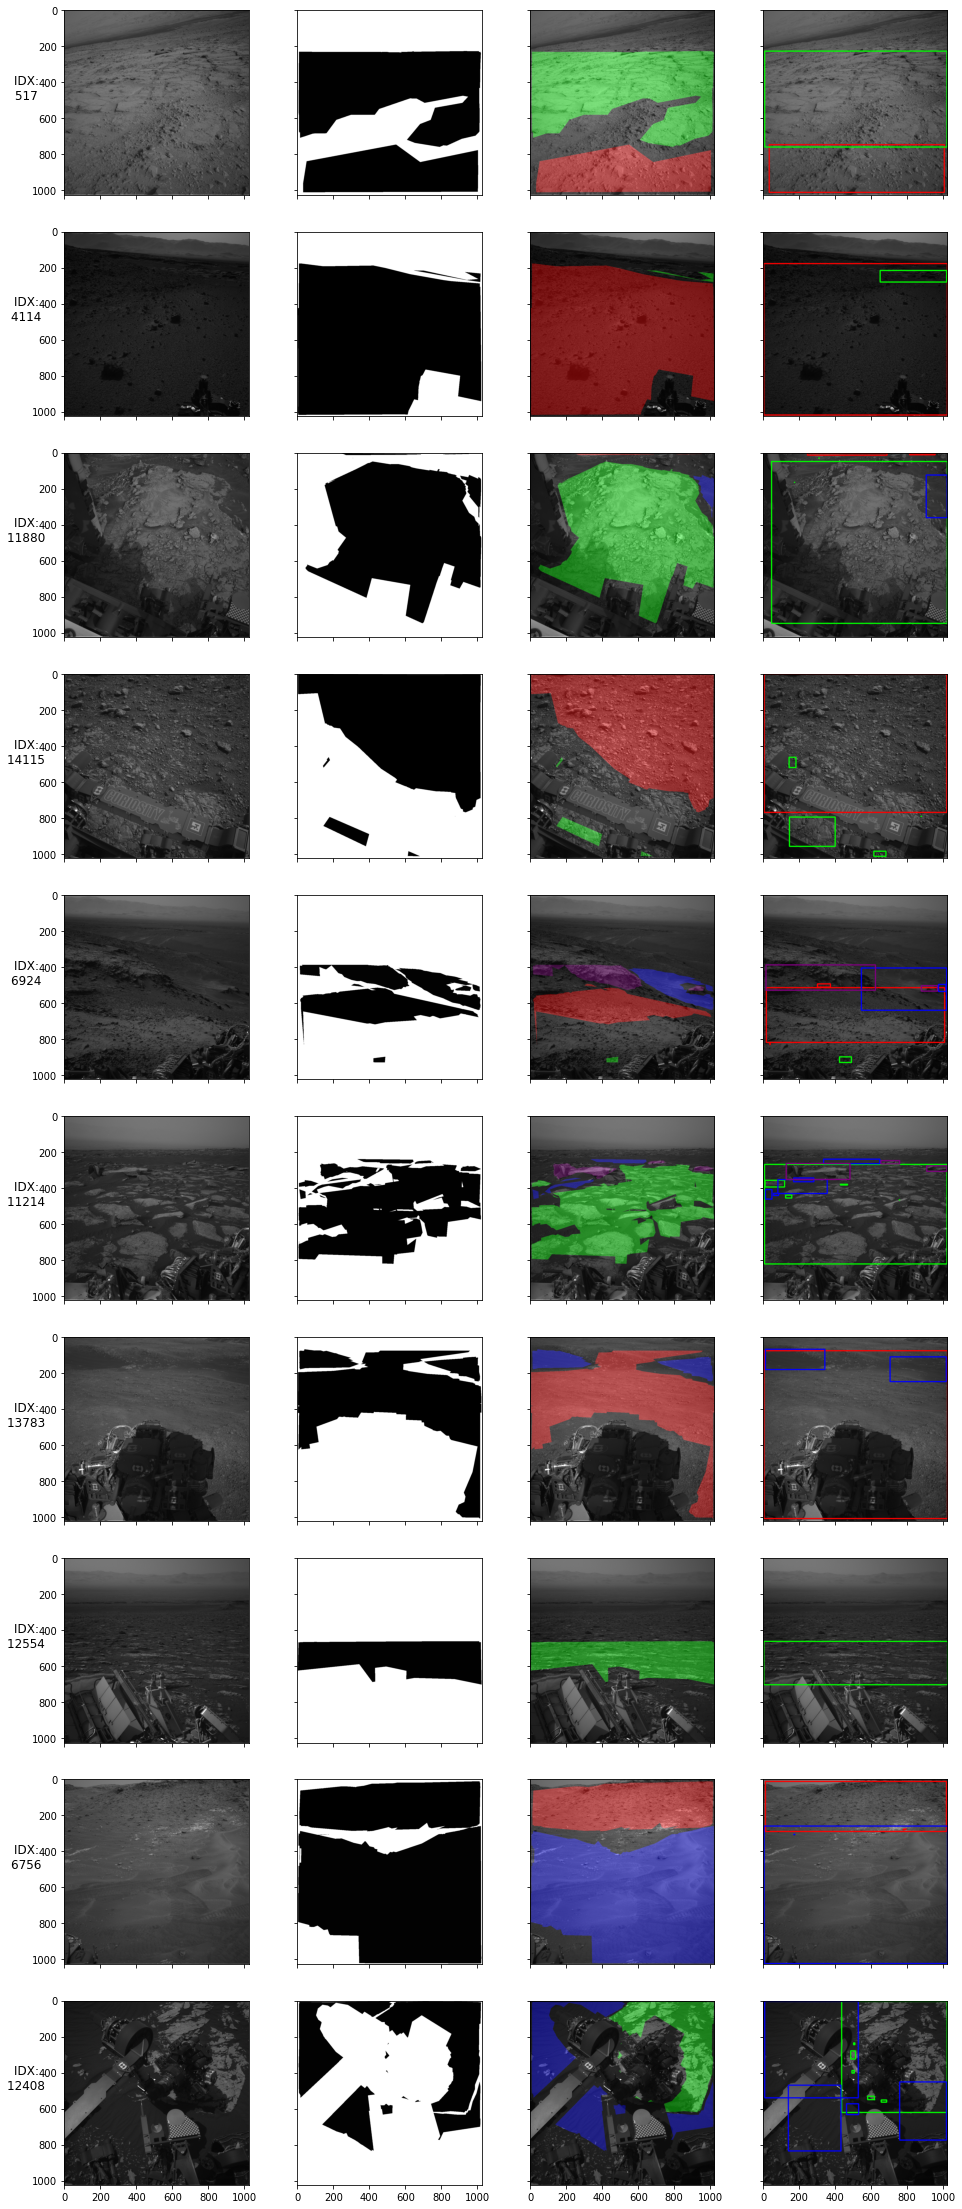

In [12]:
rand_inds = np.random.randint(len(data_util.train_label_files), size=(10,))
data_util.plot_image_with_mask_tint_and_boxes(rand_inds)

## Data Processing & Export

First we'll convert all the segmentation labels into bounding box labels.

Note that we only use the "Training" data from the AI4Mars dataset. This dataset is split into train and test when 
generated for the actual yolo model. We found that the data quality from the training set is sufficient

In [ ]:
# SKIP ME! This cell takes 15-20 mins on a laptop with 12 virtual cores
#  The output is included in the repository already, and loaded in the next section

train_meta = data_util.generate_coco_metadata(data_util.train_image_files, data_util.train_labels_dir,
                                              data_util.train_label_files, num_workers=8)
with open("train_meta_full.json", 'w') as f:
    f.write(json.dumps(train_meta))

## Data Cleaning & Conversion

### Load Metadata

We'll load the data generated in the last step

In [23]:
with open("train_meta_full.json", 'r') as f:
    train_meta = json.loads(f.read())

### Data Cleaning

The raw segment to bounding box conversion is very cluttered. We'll clean our training data using the following parameters:

- **min size:** filter out boxes that are smaller than this proportion of the total image
- **max boxes:** the image can have no more than this many boxes after filtering
- **min coverage:** the total area of all boxes must be at least this portion of the image

In [27]:
train_filtered_indices = []
train_meta_processed = {'image': [], 'label': []}

MAX_BOXES = 7
MIN_COVERAGE = 0.5
MIN_SIZE = 0.001


for i in range(len(train_meta['image'])):
    image = train_meta['image'][i]
    label = train_meta['label'][i]
    
    try:
        preprocessed = data_util.preprocess_label(label, remove_nested_boxes=True, min_coverage=MIN_COVERAGE, max_boxes=MAX_BOXES, min_box_proportional_size=MIN_SIZE)
    except ValueError as e:
        print(f"failed on {i}")
        raise e
    if preprocessed is None:
        train_filtered_indices.append(i)
    else:
        train_meta_processed['image'].append(image)
        train_meta_processed['label'].append(preprocessed.tolist())


In [28]:
with open(f"train_meta_preprocessed_{MAX_BOXES}boxes_{MIN_COVERAGE}cvr_{MIN_SIZE}sz.json", 'w') as f:
    f.write(json.dumps(train_meta_processed))

### YOLO Format Conversion

In [35]:
# load and split preprocessed data
with open(f"train_meta_preprocessed_{MAX_BOXES}boxes_{MIN_COVERAGE}cvr_{MIN_SIZE}sz.json", 'r') as f:
    processed_meta = json.loads(f.read())
    
processed_meta_df = pd.DataFrame(processed_meta)
train_meta_df, test_meta_df = train_test_split(processed_meta_df, test_size=0.25)
train_meta = train_meta_df.to_dict(orient='list')
test_meta = test_meta_df.to_dict(orient='list')

In [36]:
data_util.metadata_to_yolo_folder(metadata=test_meta, target_folder="data/yolo/test", overwrite=True)

In [37]:
data_util.metadata_to_yolo_folder(metadata=train_meta, target_folder="data/yolo/train", overwrite=True)